In [1]:
########CELLA 1###############
from google.colab import drive
import zipfile
import os

# 1. Monta Google Drive
drive.mount('/content/drive')

# 2. Configurazione Percorsi
# Assumiamo che il file sia nella root del tuo Drive.
# Se è in una sottocartella, modifica in: '/content/drive/MyDrive/NOME_CARTELLA/dataset.zip'
zip_path = '/content/drive/MyDrive/dataset.zip'
extract_to = '/content/dataset_unzipped'

# 3. Estrazione
if os.path.exists(zip_path):
    print(f"Trovato {zip_path}. Inizio estrazione...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Estrazione completata!")
else:
    print(f"❌ ERRORE: Non trovo il file '{zip_path}'.")
    print("Controlla di averlo caricato su Drive e che il nome sia esattamente 'dataset.zip' (tutto minuscolo).")

Mounted at /content/drive
Trovato /content/drive/MyDrive/dataset.zip. Inizio estrazione...
✅ Estrazione completata!


In [2]:
############CELLA 2#################
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class BookCoverDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, class_to_idx=None):
        """
        Args:
            csv_file (string): Percorso al file CSV.
            root_dir (string): Directory che contiene le immagini (224x224).
            transform (callable, optional): Trasformazioni (Tensor, Normalize).
        """
        # Lettura CSV con i parametri corretti scoperti prima (sep=; encoding=ISO...)
        self.df = pd.read_csv(csv_file, sep=';', encoding='ISO-8859-1', header=0, on_bad_lines='warn')

        self.root_dir = root_dir
        self.transform = transform

        # Ordina le classi per garantire coerenza
        self.classes = sorted(self.df['Category'].unique())

        # Mappa Stringa -> Intero
        if class_to_idx is None:
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Recupera nome file e costruisce percorso
        img_name = str(self.df.iloc[idx]['Filename'])
        img_path = os.path.join(self.root_dir, img_name)

        # Caricamento Immagine
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError):
            # Gestione immagine mancante (crea immagine nera)
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Label
        label_str = self.df.iloc[idx]['Category']
        label = self.class_to_idx[label_str]

        # Trasformazioni
        if self.transform:
            image = self.transform(image)

        return image, label

# --- CONFIGURAZIONE TRASFORMAZIONI ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # 1. RandomResizedCrop: Taglia pezzi casuali e li riporta a 224x224.
        # Costringe la rete a guardare i dettagli. scale=(0.8, 1.0) significa che prende almeno l'80% dell'immagine.
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

        transforms.RandomHorizontalFlip(),

        # 2. ColorJitter: Variazione di luminosità e contrasto (fondamentale per scansioni diverse)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

        transforms.RandomRotation(15),

        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # Nel validation NON facciamo augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
#################CELLA 3####################
# Cerchiamo i percorsi corretti navigando tra le cartelle estratte
base_search_path = '/content/dataset_unzipped'
csv_path = None
img_dir = None

print("🔍 Scansione cartelle in corso...")

for root, dirs, files in os.walk(base_search_path):
    # Cerchiamo il CSV di training
    if "book30-listing-train.csv" in files:
        csv_path = os.path.join(root, "book30-listing-train.csv")
        print(f"   -> CSV Trovato: {csv_path}")

    # Cerchiamo la cartella specifica delle immagini
    if "224x224" in dirs:
        img_dir = os.path.join(root, "224x224")
        print(f"   -> Cartella Immagini Trovata: {img_dir}")

# --- VERIFICA E CREAZIONE DATASET ---
if csv_path and img_dir:
    print("\n✅ File trovati! Creazione Dataset in corso...")

    # Creiamo il dataset
    train_dataset = BookCoverDataset(
        csv_file=csv_path,
        root_dir=img_dir,
        transform=data_transforms['train']
    )

    # TEST RAPIDO
    print(f"Dataset caricato correttamente con {len(train_dataset)} libri.")
    print(f"Numero di classi (Generi): {len(train_dataset.classes)}")

    # Verifica GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🖥️ Device attivo: {device}")
    if device.type == 'cuda':
        print("🚀 Perfetto! La GPU NVIDIA T4 è pronta a spingere.")
    else:
        print("⚠️ ATTENZIONE: Stai usando la CPU. Vai su Modifica -> Impostazioni Notebook -> Hardware Accelerator -> T4 GPU")

    # Test estrazione di un elemento
    img, label = train_dataset[0]
    print(f"\nTest Shape Tensore: {img.shape} (Deve essere 3, 224, 224)")

else:
    print("\n❌ ERRORE CRITICO: Non ho trovato i file necessari.")
    print("Controlla il contenuto dello zip. Cerco 'book30-listing-train.csv' e una cartella '224x224'.")

🔍 Scansione cartelle in corso...
   -> CSV Trovato: /content/dataset_unzipped/dataset/book30-listing-train.csv
   -> Cartella Immagini Trovata: /content/dataset_unzipped/dataset/title30cat/224x224

✅ File trovati! Creazione Dataset in corso...
Dataset caricato correttamente con 51300 libri.
Numero di classi (Generi): 30

🖥️ Device attivo: cuda
🚀 Perfetto! La GPU NVIDIA T4 è pronta a spingere.

Test Shape Tensore: torch.Size([3, 224, 224]) (Deve essere 3, 224, 224)


In [4]:
############### CELLA 4 (AGGIORNATA - BALANCED SAMPLER) ##############
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
from collections import Counter

# 1. Divisione Train / Validation (80% / 20%)
total_size = len(train_dataset)
train_len = int(0.8 * total_size)
val_len = total_size - train_len

# Manteniamo il seed fisso per riproducibilità se necessario
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"📊 Split completato:")
print(f"   -> Training Set: {len(train_subset)} immagini")
print(f"   -> Validation Set: {len(val_subset)} immagini")

# --- CALCOLO DEI PESI PER IL SAMPLER (Logica del Paper 2) ---
# Dobbiamo capire quante immagini ci sono per ogni classe nel SOLO training set
print("⚖️  Calcolo dei pesi per il bilanciamento delle classi...")

# Recuperiamo le label degli indici che sono finiti nel train_subset
# train_subset.indices contiene gli indici originali del dataset
train_indices = train_subset.indices
all_labels = [train_dataset.df.iloc[i]['Category'] for i in train_indices]

# Contiamo la frequenza di ogni classe
class_counts = Counter(all_labels)

# Calcoliamo il peso per ogni classe: Peso = 1 / Frequenza
# Le classi rare avranno un peso alto, quelle frequenti un peso basso
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Assegniamo un peso a OGNI immagine del training set
sample_weights = [class_weights[label] for label in all_labels]

# Creiamo il Sampler
# num_samples=len(train_subset) assicura che l'epoca duri quanto prima
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_subset),
    replacement=True
)

print("✅ Sampler creato! Le classi saranno bilanciate in ogni batch.")

# 2. Creazione dei DataLoader
BATCH_SIZE = 1024

# NOTA IMPORTANTE: Quando si usa un sampler, shuffle DEVE essere False
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # <--- Qui usiamo il sampler bilanciato invece di shuffle=True
    shuffle=False,
    num_workers=2
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"✅ Dataloaders pronti con Data Augmentation (Paper 3) e Balanced Sampling (Paper 2)")

📊 Split completato:
   -> Training Set: 41040 immagini
   -> Validation Set: 10260 immagini
⚖️  Calcolo dei pesi per il bilanciamento delle classi...
✅ Sampler creato! Le classi saranno bilanciate in ogni batch.
✅ Dataloaders pronti con Data Augmentation (Paper 3) e Balanced Sampling (Paper 2)


In [5]:
###############CELLA 5###################
from torchvision import models
import torch.nn as nn

def get_model(num_classes=30):
    print("Scaricamento pesi ResNet50 (ImageNet)...")
    # Scarichiamo la versione più aggiornata dei pesi
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 1. FREEZING: Congeliamo tutti i parametri
    # Questo impedisce che durante il training modifichiamo i filtri che sanno già "vedere"
    for param in model.parameters():
        param.requires_grad = False

    # 2. Sostituzione dell'ultimo layer (Fully Connected)
    # ResNet50 ha 2048 feature in ingresso all'ultimo layer
    num_ftrs = model.fc.in_features

    # Creiamo il nuovo layer classificatore.
    # Nota: Di default, i nuovi layer hanno requires_grad=True, quindi QUESTI verranno addestrati.
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512), # Strato intermedio per imparare combinazioni complesse
        nn.ReLU(),
        nn.Dropout(0.5),          # Dropout per evitare overfitting (tecnica standard)
        nn.Linear(512, num_classes) # Output finale: 30 probabilità
    )

    return model

# Istanziamo il modello e lo spostiamo sulla GPU
model = get_model(num_classes=len(train_dataset.classes))
model = model.to(device) # Sposta tutto sulla GPU T4

print("\n🤖 Modello ResNet50 caricato e modificato per 30 classi.")
print("   -> Backbone (corpo): Congelato ❄️")
print("   -> Head (testa): Pronta per l'addestramento 🔥")

Scaricamento pesi ResNet50 (ImageNet)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]



🤖 Modello ResNet50 caricato e modificato per 30 classi.
   -> Backbone (corpo): Congelato ❄️
   -> Head (testa): Pronta per l'addestramento 🔥


In [7]:
################## CELLA 6 (CON SCHEDULER) #################
import torch.optim as optim
import time
import torch.nn as nn
import copy

# --- 1. CONFIGURAZIONE SCONGELAMENTO (SOLO TESTA) ---
print("🔒 Congelamento di tutta la rete...")
for param in model.parameters():
    param.requires_grad = False

print("🔓 Scongelamento SOLO della Testa (FC)...")
for param in model.fc.parameters():
    param.requires_grad = True

# Raccogliamo i parametri da aggiornare
params_to_update = [p for p in model.parameters() if p.requires_grad]

# --- 2. CONFIGURAZIONE TRAINING ---
criterion = nn.CrossEntropyLoss()

# Optimizer (LR iniziale, magari aumentalo leggermente per batch 1024, es: 0.005 o 0.01)
# Qui lascio 0.001 come base, ma sentiti libero di alzarlo se vedi che apprende piano.
optimizer = optim.Adam(params_to_update, lr=0.001)

# --- SCHEDULER ---
# Se la val_loss non scende per 'patience' epoche, moltiplica il LR per 'factor'.
# patience=3: aspetta 3 epoche.
# factor=0.1: riduce il LR a un decimo (es. da 0.001 a 0.0001).
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Numero di Epoche e Pazienza Early Stopping
NUM_EPOCHS = 30

ES_PATIENCE = 6

# --- 3. FUNZIONE DI TRAINING ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, es_patience=6):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Stampa LR corrente
        curr_lr = optimizer.param_groups[0]['lr']
        print(f"📉 Current Learning Rate: {curr_lr}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # STEP SCHEDULER: Controlla la loss di validazione
                # Se non scende da 3 epoche, abbasserà il LR per la prossima
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- EARLY STOPPING ---
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    print(f"✅ Miglioramento! (Patience azzerata)")
                else:
                    patience_counter += 1
                    print(f"⚠️ Nessun miglioramento. ES Patience: {patience_counter}/{es_patience}")

        if patience_counter >= es_patience:
            print(f"\n⏹️ Early Stopping attivato! Stop training.")
            break

    time_elapsed = time.time() - start_time
    print(f'\nAddestramento completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Loss: {best_val_loss:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# --- AVVIO TRAINING ---
print("🚀 Inizio Addestramento (Scheduler + Early Stopping)...")
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, es_patience=ES_PATIENCE)

🔒 Congelamento di tutta la rete...
🔓 Scongelamento SOLO della Testa (FC)...
🚀 Inizio Addestramento (Scheduler + Early Stopping)...

Epoch 1/30
----------
📉 Current Learning Rate: 0.001
train Loss: 3.0284 Acc: 0.1735
val Loss: 2.8299 Acc: 0.2185
✅ Miglioramento! (Patience azzerata)

Epoch 2/30
----------
📉 Current Learning Rate: 0.001
train Loss: 2.7662 Acc: 0.2372
val Loss: 2.7421 Acc: 0.2414
✅ Miglioramento! (Patience azzerata)

Epoch 3/30
----------
📉 Current Learning Rate: 0.001
train Loss: 2.6789 Acc: 0.2566
val Loss: 2.7101 Acc: 0.2455
✅ Miglioramento! (Patience azzerata)

Epoch 4/30
----------
📉 Current Learning Rate: 0.001
train Loss: 2.6276 Acc: 0.2687
val Loss: 2.6828 Acc: 0.2558
✅ Miglioramento! (Patience azzerata)

Epoch 5/30
----------
📉 Current Learning Rate: 0.001
train Loss: 2.5809 Acc: 0.2760
val Loss: 2.6708 Acc: 0.2587
✅ Miglioramento! (Patience azzerata)

Epoch 6/30
----------
📉 Current Learning Rate: 0.001
train Loss: 2.5543 Acc: 0.2852
val Loss: 2.6675 Acc: 0.2557


Generazione grafico in corso...
📊 Calcolo delle predizioni sul Validation Set...


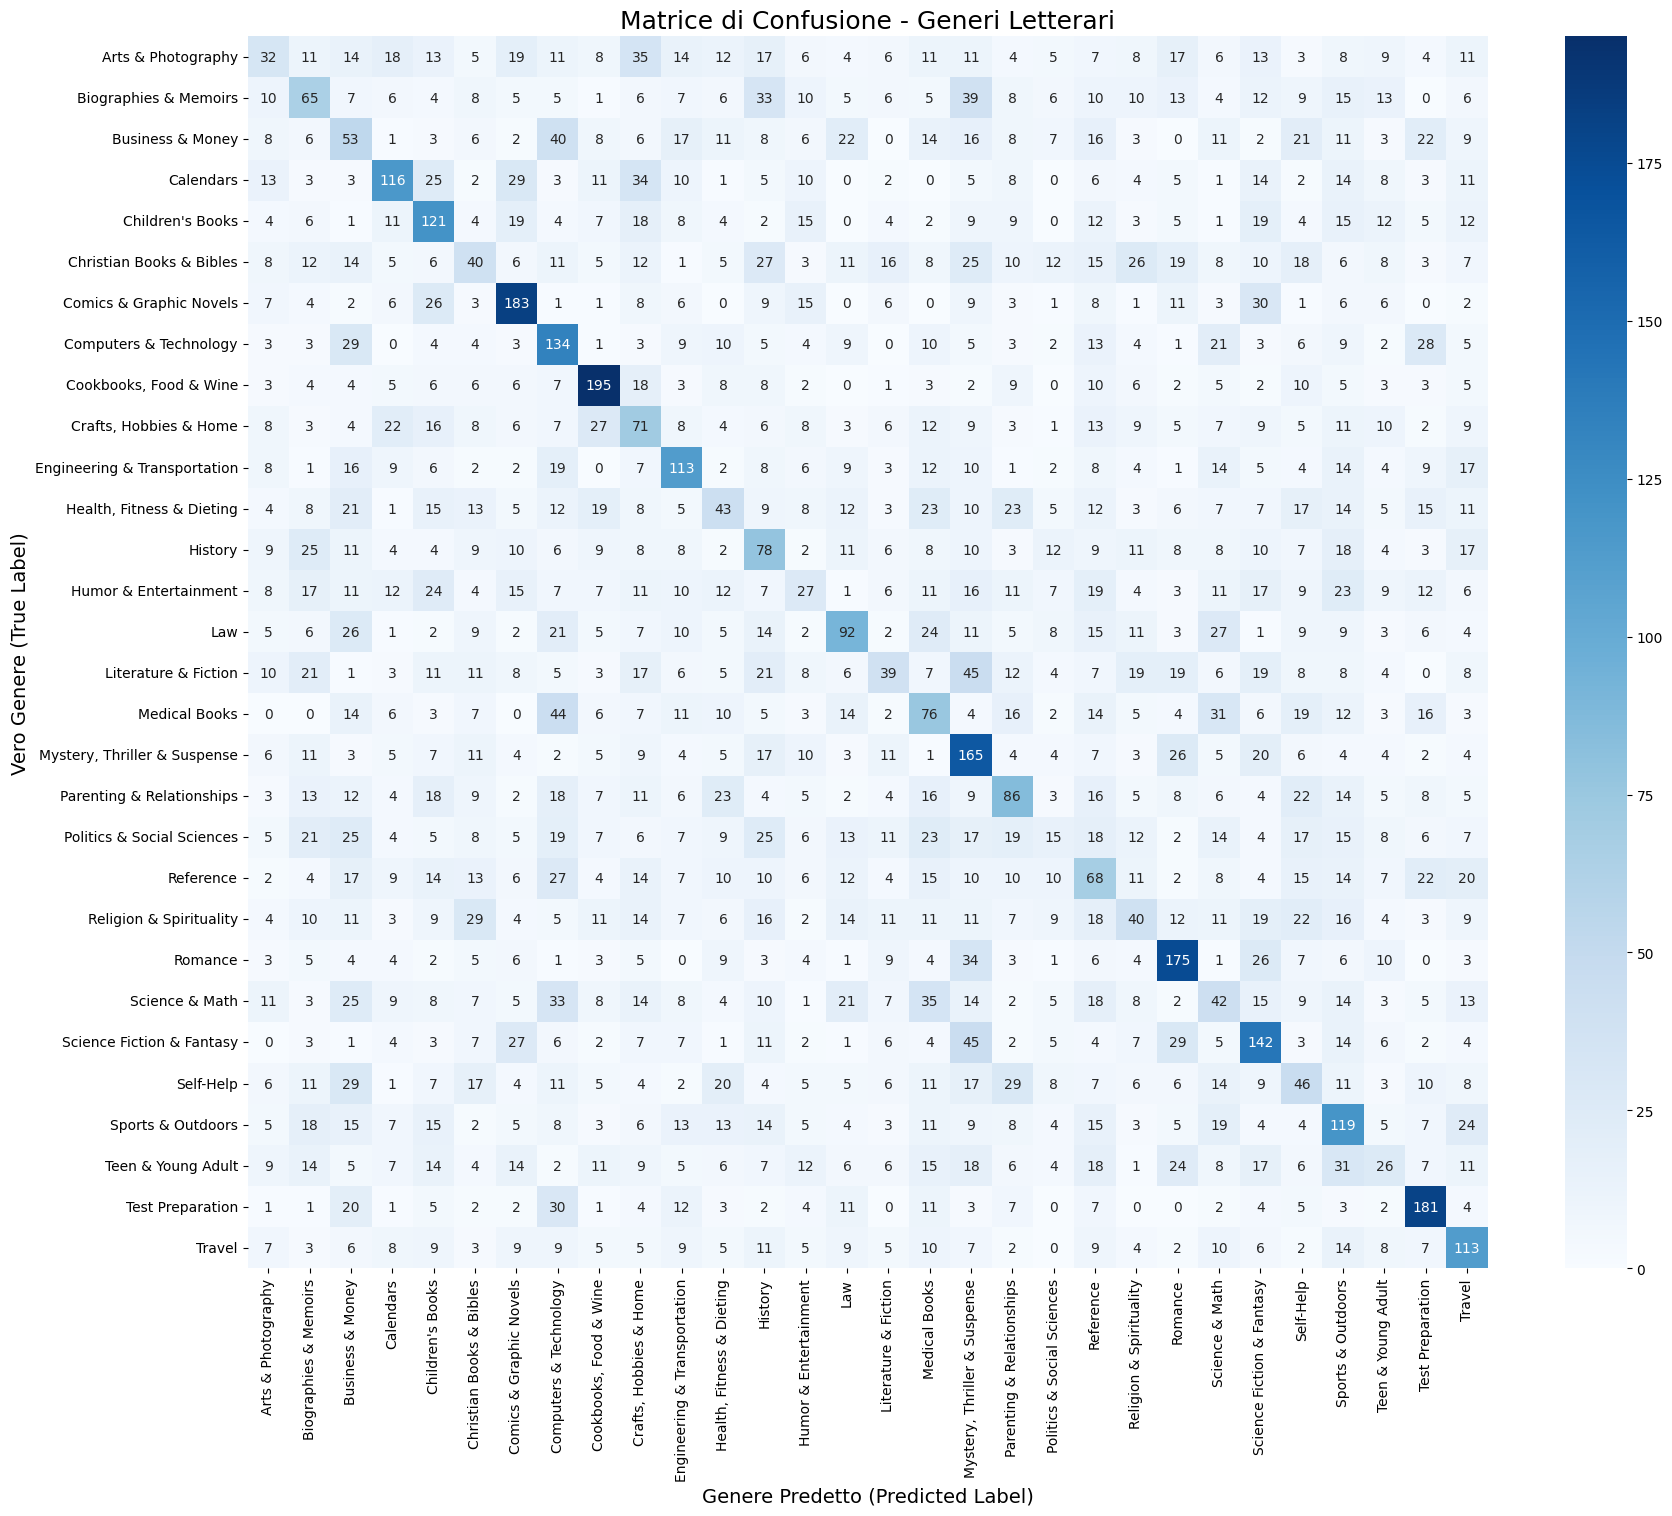

In [8]:
##################CELLA 7#################
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, dataloader, classes):
    model.eval() # Modalità valutazione
    y_true = []
    y_pred = []

    print("📊 Calcolo delle predizioni sul Validation Set...")
    with torch.no_grad(): # Disabilita il calcolo dei gradienti (risparmia memoria)
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Spostiamo su CPU e convertiamo in numpy
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calcolo della matrice
    cm = confusion_matrix(y_true, y_pred)

    # Normalizzazione (opzionale, per vedere le % invece dei numeri assoluti)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(20, 16)) # Dimensioni grandi per farci stare 30 classi
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.ylabel('Vero Genere (True Label)', fontsize=14)
    plt.xlabel('Genere Predetto (Predicted Label)', fontsize=14)
    plt.title('Matrice di Confusione - Generi Letterari', fontsize=18)
    plt.xticks(rotation=90) # Ruota le etichette per leggerle meglio
    plt.yticks(rotation=0)
    plt.show()

# Eseguiamo la funzione usando il modello addestrato
# Assicurati che 'trained_model' sia disponibile (dopo la Cella 6)
print("Generazione grafico in corso...")
plot_confusion_matrix(trained_model, val_loader, train_dataset.classes)

In [9]:
################## CELLA 8#################
#METRICHE PAPER (TOP-1, TOP-2, TOP-3)
def evaluate_paper_metrics(model, dataloader):
    model.eval()

    correct_top1 = 0
    correct_top2 = 0
    correct_top3 = 0
    total = 0

    print("📏 Calcolo metriche Top-k (Come nel Paper)...")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Calcoliamo l'output del modello
            outputs = model(inputs)

            # 2. Prendiamo le prime 3 predizioni più alte (Top-3)
            # k=3 perché ci servono Top-1, Top-2 e Top-3
            _, max_k_preds = torch.topk(outputs, k=3, dim=1)

            # 3. Trasponiamo la matrice per facilitare il confronto
            # Ora max_k_preds ha shape [3, batch_size]
            max_k_preds = max_k_preds.t()

            # 4. Creiamo una matrice di etichette ripetute per confrontarle
            target_expanded = labels.view(1, -1).expand_as(max_k_preds)

            # 5. Confronto: Otteniamo una matrice di True/False
            # Se la cella (k, i) è True, vuol dire che la k-esima predizione per l'immagine i è corretta
            correct = max_k_preds.eq(target_expanded)

            # --- AGGIORNAMENTO CONTATORI ---

            # Top-1: Controlliamo solo la prima riga (la predizione #1)
            correct_top1 += correct[:1].reshape(-1).float().sum(0, keepdim=True)

            # Top-2: Controlliamo le prime due righe (predizione #1 O predizione #2)
            correct_top2 += correct[:2].reshape(-1).float().sum(0, keepdim=True)

            # Top-3: Controlliamo le prime tre righe
            correct_top3 += correct[:3].reshape(-1).float().sum(0, keepdim=True)

            total += labels.size(0)

    # Calcolo percentuali finali
    acc_top1 = correct_top1.item() / total * 100
    acc_top2 = correct_top2.item() / total * 100
    acc_top3 = correct_top3.item() / total * 100

    print(f"\n📊 RISULTATI DEL PAPER (su {total} immagini di test):")
    print("-" * 40)
    print(f"🔹 Top-1 Accuracy: {acc_top1:.2f}%  (Paper AlexNet: 24.7%)")
    print(f"🔹 Top-2 Accuracy: {acc_top2:.2f}%  (Paper AlexNet: 33.1%)")
    print(f"🔹 Top-3 Accuracy: {acc_top3:.2f}%  (Paper AlexNet: 40.3%)")
    print("-" * 40)
    return acc_top1, acc_top2, acc_top3

# Esegui la valutazione
evaluate_paper_metrics(trained_model, val_loader)

📏 Calcolo metriche Top-k (Come nel Paper)...

📊 RISULTATI DEL PAPER (su 10260 immagini di test):
----------------------------------------
🔹 Top-1 Accuracy: 26.07%  (Paper AlexNet: 24.7%)
🔹 Top-2 Accuracy: 38.18%  (Paper AlexNet: 33.1%)
🔹 Top-3 Accuracy: 46.31%  (Paper AlexNet: 40.3%)
----------------------------------------


(26.072124756335285, 38.177387914230025, 46.306042884990255)